## Load relevant packages

In [242]:
# Import all the required packages
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import itertools
from copy import deepcopy
import re
%matplotlib inline

## Load relevant data files

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
# For each data file, we write which column contains the information we want to predict
topredictcolumn= ["Survived"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

# Temporary work

This particular problem is a classification problem; we are not trying to obtain the value of some parameter, e.g. how much a customer will spend in the future.

However, it might still be useful to try and predict such parameters, e.g. the age of passengers. This might improve survival predictions, but regarless it is a good exercise to do.

In [3]:
thedataframe = deepcopy(alldataframes[0])
datacateg = {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C",
             'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
             'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
uselesscols = ["Name", "Ticket"]
dictofunknown = {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
                 "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", 
                 "Age": alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0], 
                 "Nationality": "Unknown"}
orderings = [
    {"Pclass": [1,2,3]} #NB only need to include columns that are not numeric!
]
dictofordinals = {"Pclass": [1,2,3]}

## Regression
### Functions for making predictions based on given model

In [4]:
# Returns the intercept, parameters, Rscore (where 1.0 is perfect prediction, and percentage of cases
# correctly predicted. The final two are given as tuple (score, errorbarsonscore). X is the data we use 
# to predict y; predictionmethod is the name of our model, e.g. linear_model.LinearRegression; rounddecimals
# equals the number of decimals allowed for our prediction, e.g. when predicting integers rounddecimals=0; 
# num_iterations is the number of times we run the function to obtain the parameters, and kwargs are any 
# additional optional parameters we want to pass on to predictionmethod.
def getParametersAndPredictionScore(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    parameters = []
    intercept = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            parameters.append(predictor.coef_)
            intercept.append(predictor.intercept_)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    parameters = np.mean(parameters, axis=0)
    intercept = np.mean(intercept)
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (intercept, parameters, score, predictedpercent)
    else:
        toreturn = (intercept, parameters, score)
    return toreturn

def getPredictionPercentage(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (score, predictedpercent)
    else:
        toreturn = (score)
    return toreturn

# Returns the prediction accuracy (+/- errorbars on the accuracy) when classifying "at random", i.e. 
# by always predicting the same thing for all the elements. We try by predicting the mean, or the 
# median, or the most frequently occurring element
def randomPrediction(y, rounddecimals="none", num_iterations=1):
    meanscore = []
    medianscore = []
    mostfrequentscore = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            ytrain, ytest = y[trainindex], y[testindex]
            mean = np.mean(ytrain)
            median = np.median(ytrain)
            mostfrequent = max(set(list(y)), key=list(ytrain).count)
            if rounddecimals!="none":
                mean = np.round(mean, decimals=rounddecimals)
            meanscore.append((ytest==mean).mean())
            medianscore.append((ytest==median).mean())
            mostfrequentscore.append((ytest==mostfrequent).mean())
    meanscore = (np.mean(meanscore), np.std(meanscore))
    medianscore = (np.mean(medianscore), np.std(medianscore))
    mostfrequentscore = (np.mean(mostfrequentscore), np.std(mostfrequentscore))
    allscores = [meanscore[0], medianscore[0], mostfrequentscore[0]]
    return [meanscore, medianscore, mostfrequentscore][allscores.index(max(allscores))]

#### Helper functions

In [5]:
def transformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = np.sqrt(outputdata[outputdata>0])
        outputdata[outputdata<0] = -np.sqrt(-outputdata[outputdata<0])
    if transform=="log":
        outputdata[outputdata>1] = np.log(outputdata[outputdata>1])+1
        outputdata[outputdata<-1] = -np.log(-outputdata[outputdata<-1])-1
    return outputdata

def inverseTransformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = outputdata[outputdata>0]**2
        outputdata[outputdata<0] = -((-outputdata[outputdata<0])**2)
    if transform=="log":
        outputdata[outputdata>1] = np.e**(outputdata[outputdata>1]-1)
        outputdata[outputdata<-1] = -(np.e**(-outputdata[outputdata<-1] -1))
    return outputdata

def scaleData(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)  # Need to fit only on training data, not evaluation data!
    scaledX_train = scaler.transform(X_train)
    scaledX_test = scaler.transform(X_test)  # we apply same transformation to test data
    return (scaledX_train, scaledX_test)

#This function removes those rows in "inputdataframe" where data was generated automatially 
# in the column "columnofinterest". "dictofunknown" contains the information on what data was
# generated automatically.
def removeAutogeneratedData(inputdataframe, columnsofinterest, dictofunknown):
    if type(columnsofinterest)==str:
        allcolumnsofinterest = [columnsofinterest]
    else:
        allcolumnsofinterest = columnsofinterest
    outputdataframe = deepcopy(inputdataframe)
    for col in allcolumnsofinterest:
        if col in dictofunknown:
            outputdataframe = outputdataframe[outputdataframe[col]!= dictofunknown[col]]
    return outputdataframe

# Helper function that takes a model, e.g. linear_model.LinearRegression,
# and returns the name of that model, e.g. "LinearRegression"
def getModelName(currentmodel):
    modelname = str(currentmodel)
    modelname = modelname[modelname.rfind(".")+1:]
    extracharacters = re.search("[^a-zA-z]",modelname)
    if type(extracharacters)!=type(None):
        modelname = modelname[:extracharacters.start()]
    return modelname

# Returns the same dataframe but where the ordinal data has been replaced with numbers, and hence can
# be ordered correctly. When plotting it will be necessary to replace the numbers back to their
# original categorical labels.
def orderOrdinalData(thedataframe, dictofordinals):
    orderedordinalsframe = deepcopy(thedataframe)
    # We need to turn the dictionary dictofordinals into a form good for using pandas .replace(dict)
    neworderings = deepcopy(dictofordinals)
    for key in neworderings:
        # Pandas complains if we have intersections between the keys and the values
        intersectionlength = len(set(neworderings[key]).intersection(set(range(1,len(neworderings[key])+1))))
        if intersectionlength==0:
            # We can just replace the entries with 0,1,2,...,num_categories-1
            neworderings[key] = dict([(el,ii+1) for ii,el in enumerate(neworderings[key])])
        else:
            # We replace with '0',1','2',.... instead. We will later turn the strings into ints.
            neworderings[key] = dict([(el,str(ii+1)) for ii,el in enumerate(neworderings[key])])
    # Now we'll replace the ordinal columns in the dataframes with numeric labels
    if dictofordinals!={}:
        orderedordinalsframe.replace(neworderings, inplace=True)
        for key in neworderings.keys():
            orderedordinalsframe.loc[:,key] = pd.to_numeric(orderedordinalsframe[key])
    return (orderedordinalsframe, neworderings)

def makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg):
    ordereddataframe = orderOrdinalData(thedataframe, dictofordinals)[0]
    replacementdict = {}
    for col in ordereddataframe:
        if datacateg[col]=="C":
            allcategories = sorted(ordereddataframe[col].unique())
            replacementdict[col] = dict([(cat,ii) for ii, cat in enumerate(allcategories)])
    ordereddataframe.replace(replacementdict, inplace=True)
    return (ordereddataframe, replacementdict)

### Implement all linear regressions

In [6]:
def tryAllLinearRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LinearRegression, linear_model.RidgeCV, linear_model.LassoCV, 
                      linear_model.BayesianRidge, linear_model.SGDRegressor]
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDRegressor:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, n_alphas=3,
                                                        classifier=classifier, transform=transformtouse)
        else:
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, classifier=classifier,
                                                        transform=transformtouse)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

# Makes a scatterplot of the error in prediction, versus the predicted value, to see if there
# is any heteroscedasticity, i.e. to see if the error bars of our prediction depend on the value
# of the prediction. Returns the R^2 value of the prediction.
def plotErrors(thedataframe, topredict, frompredict, chosenmodel, dictofregressions, 
               rounddecimals="none", minvalue="none", maxvalue="none", ax="none", dictofunknown={}, 
               alpha=0.3, transform="none"):
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    if transform!="none":
        X = transformData(X, transform=transform)
    coefficients = dictofregressions[chosenmodel][1]
    intercept = dictofregressions[chosenmodel][0]
    prediction = np.dot(X,coefficients) + intercept
    if transform!="none":
        prediction = inverseTransformData(prediction, transform=transform)
    if rounddecimals!="none":
        prediction = np.round(prediction, decimals=rounddecimals)
    if minvalue!="none":
        prediction[prediction < minvalue] = minvalue
    if maxvalue!="none":
        prediction[prediction > maxvalue] = maxvalue
    if ax=="none":
        plt.scatter(prediction, prediction - y, alpha=alpha)
        plt.xlabel("Predicted " + topredict)
        plt.ylabel("Error in prediction")
        plt.show()
    else:
        ax.scatter(prediction, prediction - y, alpha=alpha)
        ax.set_xlabel("Predicted " + topredict)
        ax.set_ylabel("Error in prediction")
    print "Mean: %f" %np.mean(prediction - y)
    print "Std: %f" %np.std(prediction - y)
    print "R^2: %f" %(np.var(prediction) / np.var(y))

#### Helper functions

In [7]:
def makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown):
    tousedataframe = removeAutogeneratedData(thedataframe, frompredict + [topredict], dictofunknown)
    X = tousedataframe[frompredict].as_matrix()
    y = tousedataframe[topredict].as_matrix()
    return (X,y)

### Functions for using regressions to fill in unknown data

In [8]:
# Makes a dataframe where the values of topredict have been predicted using frompredict, with the regression 
# model called chosenmodel (a string). For this we need to have found all regressions, placed in the variable
# dictofregressions.
def incorporateRegressionPrediction(inputdataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                    rounddecimals="none", minvalue="none", maxvalue="none", transform="none"):
    thedataframe = deepcopy(inputdataframe)
    if topredict in dictofunknown:
        topredictframe = thedataframe[thedataframe[topredict]==dictofunknown[topredict]]
    else:
        topredictframe = thedataframe[thedataframe[topredict].isnull()]
    ind = topredictframe.index
    dataX = topredictframe[frompredict].as_matrix()
    if transform!="none":
        dataX = transformData(dataX, transform=transform)
    if len(dataX) > 0:
        coefficients = dictofregressions[chosenmodel][1]
        intercept = dictofregressions[chosenmodel][0]
        prediction = np.dot(dataX,coefficients) + intercept
        if transform!="none":
            prediction = inverseTransformData(prediction, transform=transform)
        if rounddecimals!="none":
            prediction = np.round(prediction, decimals=rounddecimals)
        if minvalue!="none":
            prediction[prediction < minvalue] = minvalue
        if maxvalue!="none":
            prediction[prediction > maxvalue] = maxvalue
        thedataframe.loc[ind, topredict] = prediction
    return thedataframe

### Use linear regression for missing data

After having tried various options, it seems like using transform="log" we're able to avoid most of the heteroscedasticity we otherwise get with a straightforward linear regression.

In [9]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Age"
frompredict = ['Pclass', 'Sex', 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
tousedataframe = deepcopy(numericdataframe)
transform = "log"

linearregressions = tryAllLinearRegressions(tousedataframe, topredict, frompredict,
                                            dictofunknown={'Age': 29.6991176471}, printout=True, num_iterations=100, 
                                            rounddecimals="none", classifier=False, transform=transform)

LinearRegression
	The score on the fit is 0.227193 ± 0.082077 (1.0 is perfect)
RidgeCV
	The score on the fit is 0.231368 ± 0.069382 (1.0 is perfect)
LassoCV
	The score on the fit is 0.231513 ± 0.075897 (1.0 is perfect)
BayesianRidge
	The score on the fit is 0.229169 ± 0.071126 (1.0 is perfect)
SGDRegressor
	The score on the fit is 0.210007 ± 0.060242 (1.0 is perfect)


### Check heteroscedasticity of fit

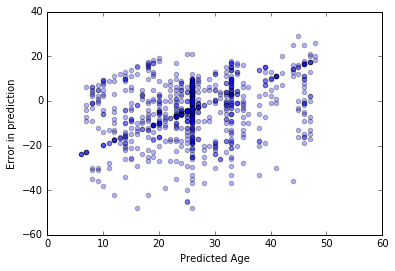

Mean: -3.662467
Std: 12.412592
R^2: 0.493275


In [10]:
chosenmodel = "LinearRegression"
dictofregressions = linearregressions
rounddecimals=0
minvalue=0
maxvalue=100

plotErrors(tousedataframe, topredict, frompredict, chosenmodel, dictofregressions,
           rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, ax="none", transform=transform)

### Make new datafram with predicted values

In [11]:
newdataframe = incorporateRegressionPrediction(tousedataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                               rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, 
                                               transform=transform)

## Classification
### Generic functions for making predictions and checking their accuracy

In [12]:
def getPrediction(trainX, trainy, dataX, predictionmethod, transform="none",**kwargs):
    (Xtraining, ytraining) = (trainX, trainy)
    X = dataX
    if transform!="none":
        Xtraining = transformData(trainX, transform=transform)
        X = transformData(dataX, transform=transform)
    if transform=="scale":
        (Xtraining, X) = scaleData(Xtraining, X)
    predictor = predictionmethod(**kwargs)
    predictor.fit(Xtraining,ytraining)
    predictedy = predictor.predict(X)
    return predictedy

def getPredictionProba(trainX, trainy, dataX, predictionmethod, transform="none",**kwargs):
    (Xtraining, ytraining) = (trainX, trainy)
    X = dataX
    if transform!="none":
        Xtraining = transformData(trainX, transform=transform)
        X = transformData(dataX, transform=transform)
    if transform=="scale":
        (Xtraining, X) = scaleData(Xtraining, X)
    predictor = predictionmethod(**kwargs)
    predictor.fit(Xtraining,ytraining)
    predictedy = predictor.predict_proba(X)
    return predictedy

def getPredictionScore(inputX, inputy, predictionmethod, num_iterations=1, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        X = transformData(inputX, transform=transform)
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    return score

### Functions for making classification through regression

In [13]:
def tryAllLinRegClassifiers(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=30, 
                            rounddecimals=0, printout=True, transform="scale", polynomialdegrees=[1]):
    linregs = tryPolynomialRegressions(thedataframe, topredict, frompredict, polynomialdegrees,
                                       dictofunknown=dictofunknown, num_iterations=num_iterations,
                                       rounddecimals=rounddecimals, printout=printout, classifier=True, transform=transform)
    otherregs = tryOtherRegressions(thedataframe, topredict, frompredict,
                                    dictofunknown=dictofunknown, num_iterations=num_iterations,
                                    rounddecimals=rounddecimals, printout=printout, classifier=True, transform="none")
    linregs.update(otherregs)
    regclassifiers = tryAllRegressionClassifiers(thedataframe, topredict, frompredict, polynomialdegrees, 
                                                 dictofunknown=dictofunknown, num_iterations=num_iterations, 
                                                 printout=printout, transform=transform)
    linregs.update(regclassifiers)
    otherclass = tryOtherClassifiers(thedataframe, topredict, frompredict, dictofunknown=dictofunknown, 
                                     num_iterations=num_iterations, printout=printout, transform=transform)
    linregs.update(otherclass)
    return linregs

#### Helper functions

In [196]:
def tryAllRegressionClassifiers(thedataframe, topredict, frompredict, polynomialdegrees, dictofunknown={}, num_iterations=100, 
                            printout=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LogisticRegression, linear_model.LogisticRegressionCV, linear_model.SGDClassifier,
                      linear_model.Perceptron]
    
    if type(polynomialdegrees)==int:
        alldegrees = [polynomialdegrees]
    else:
        alldegrees = polynomialdegrees
    
    randomprediction = randomPrediction(y, num_iterations=num_iterations)
    
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDClassifier or model==linear_model.Perceptron:
            transformtouse = "scale"
        for polydegree in alldegrees:
            poly = PolynomialFeatures(degree=polydegree)
            polyX = poly.fit_transform(X)
            if printout==True:
                print "\tPolynomial of degree " + str(polydegree)
            if "n_alphas" in model().get_params():
                modelscore = getPredictionScore(polyX, y, model, num_iterations=num_iterations, n_alphas=3, 
                                                transform=transformtouse)
            else:
                modelscore = getPredictionScore(polyX, y, model, num_iterations=num_iterations, transform=transformtouse)
            modelandresults[modelname] = modelscore
            if printout==True:
                print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryPolynomialRegressions(thedataframe, topredict, frompredict, polynomialdegrees, dictofunknown={}, num_iterations=100, 
                             rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LinearRegression, linear_model.RidgeCV, linear_model.LassoCV, 
                      linear_model.BayesianRidge, linear_model.SGDRegressor]
    
    if type(polynomialdegrees)==int:
        alldegrees = [polynomialdegrees]
    else:
        alldegrees = polynomialdegrees
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDRegressor or model==linear_model.Perceptron:
            transformtouse = "scale"
        for polydegree in alldegrees:
            poly = PolynomialFeatures(degree=polydegree)
            polyX = poly.fit_transform(X)
            if printout==True:
                print "\tPolynomial of degree " + str(polydegree)
            if "n_alphas" in model().get_params():
                modeldata = getParametersAndPredictionScore(polyX, y, model, rounddecimals=rounddecimals, 
                                                            num_iterations=num_iterations, n_alphas=3,
                                                            classifier=classifier, transform=transformtouse)
            else:
                modeldata = getParametersAndPredictionScore(polyX, y, model, rounddecimals=rounddecimals, 
                                                            num_iterations=num_iterations, classifier=classifier,
                                                            transform=transformtouse)
            modelandresults[(modelname,polydegree)] = modeldata
            if printout==True:
                print u"\t\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[2]
                if classifier==True:
                    print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                    print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryOtherRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                        rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [KernelRidge, GaussianProcessRegressor]
       
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDRegressor or model==linear_model.Perceptron:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modeldata = getPredictionPercentage(X, y, model, rounddecimals=rounddecimals, 
                                                num_iterations=num_iterations, n_alphas=3,
                                                classifier=classifier, transform=transformtouse)
        else:
            modeldata = getPredictionPercentage(X, y, model, rounddecimals=rounddecimals, 
                                                num_iterations=num_iterations, classifier=classifier,
                                                transform=transformtouse)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[0]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryOtherClassifiers(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            printout=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [SVC, KNeighborsClassifier, NearestCentroid, GaussianProcessClassifier, GaussianNB, 
                      DecisionTreeClassifier]
      
    randomprediction = randomPrediction(y, num_iterations=num_iterations)
    
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDClassifier or model==linear_model.Perceptron or model==SVC:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modelscore = getPredictionScore(X, y, model, num_iterations=num_iterations, n_alphas=3, 
                                            transform=transformtouse)
        else:
            modelscore = getPredictionScore(X, y, model, num_iterations=num_iterations, transform=transformtouse)
        modelandresults[modelname] = modelscore
        if printout==True:
            print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
            print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

In [123]:
topredict = "Survived"
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']

allmodelsandresults = tryAllLinRegClassifiers(numericdataframe, topredict, frompredict, num_iterations=10, 
                        transform="scale", polynomialdegrees=[1,2,3])

LinearRegression
	Polynomial of degree 1
		The score on the fit is 0.385567 ± 0.072040 (1.0 is perfect)
		The percentage of correct identifications is: 0.792337 ± 0.032700
		         Benchmark from random prediction is: 0.610721 ± 0.030026
	Polynomial of degree 2
		The score on the fit is 0.394577 ± 0.109934 (1.0 is perfect)
		The percentage of correct identifications is: 0.808112 ± 0.025592
		         Benchmark from random prediction is: 0.610721 ± 0.030026
	Polynomial of degree 3
		The score on the fit is -56659974472985780224.000000 ± 396619821310900502528.000000 (1.0 is perfect)
		The percentage of correct identifications is: 0.759917 ± 0.029648
		         Benchmark from random prediction is: 0.610721 ± 0.030026
RidgeCV
	Polynomial of degree 1
		The score on the fit is 0.384513 ± 0.054452 (1.0 is perfect)
		The percentage of correct identifications is: 0.794180 ± 0.022861
		         Benchmark from random prediction is: 0.610721 ± 0.030026
	Polynomial of degree 2
		The score on the 

In [251]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
#frompredict = ['Pclass', 'Sex', 'SibSp']

(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})
getPredictionScore(X, y, BaggingRegressor, num_iterations=100, transform="scale", 
                   base_estimator=linear_model.LinearRegression(), n_estimators=100, max_samples=1.0, max_features=1.0)

(0.38540962734759276, 0.056074973976286427)

In [250]:
getPredictionScore(X, y, linear_model.LinearRegression, num_iterations=100, transform="scale")

(0.38564262241829589, 0.057886751597330276)

#### Find ideal number of neighbors

In [19]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
#frompredict = ['Pclass', 'Sex', 'SibSp']

(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})
allscores = []
for jj in range(1,20):
    allscores.append(getPredictionScore(X, y, KNeighborsClassifier, num_iterations=30, transform="scale", n_neighbors=jj)[0])

# if we decrease wrt a value twice in a row, we've reached the max
bestnumneighbors = list(np.append(
    (np.array(allscores[2:]) - np.array(allscores[:-2]) < 0).astype(int), 
    1) * (np.array(allscores[1:]) - np.array(allscores[:-1]) < 0).astype(int)).index(1) + 1

Ideal number is 14


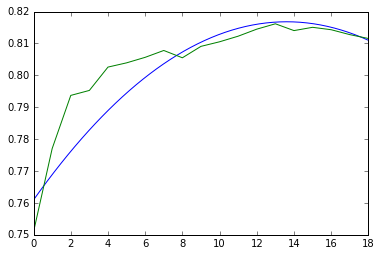

In [20]:
poly = PolynomialFeatures(degree=2)
polyX = poly.fit_transform((np.arange(len(allscores))+1).reshape(-1, 1))
linreg = linear_model.LinearRegression()
linreg.fit(polyX,np.array(allscores).reshape(-1, 1))
xs = np.linspace(0,18)
plt.plot(xs, linreg.intercept_ + linreg.coef_[0][0] + linreg.coef_[0][1]*xs + linreg.coef_[0][2]*(xs**2))
plt.plot(allscores)
print "Ideal number is %d" %np.round(-linreg.coef_[0][1]/(2*linreg.coef_[0][2]))

### Ensemble

In [201]:
def getPredictAccur(predictionmethod):
    try:
        predictionaccuracy = allmodelsandresults[(getModelName(predictionmethod),polydegree)][-1][0]
    except KeyError:
        predictionaccuracy = allmodelsandresults[getModelName(predictionmethod)][0]
    return predictionaccuracy

# ================================================
# THESE FUNCTIONS ARE FOR ESTIMATING THE CORRECT VALUES BASED ON A BAYES-LIKE PROB OF THE RIGHT ANSWER
def getprob(result, event, prob):
    if result==event:
        chance = prob 
    else:
        chance = 1 - prob
    return chance

def getConsensusResult(resultlist, probs):
    prob1 = [getprob(result, 1,prob) for prob,result in zip(probs,resultlist)]
    prob0 = [getprob(result, 0,prob) for prob,result in zip(probs,resultlist)]
    #ratio = (np.mean(y)/(1-np.mean(y)))* np.prod(prob1)/np.prod(prob0)
    ratio = np.prod(prob1)/np.prod(prob0)
    probshouldbe1 = ratio / (1+ratio)
    consensusresult = np.round(probshouldbe1)
    return consensusresult
# ================================================


num_iterations = 100
polydegree = 2
modelstotryout = [linear_model.RidgeCV, linear_model.SGDRegressor, linear_model.LogisticRegression, 
                  SVC, KNeighborsClassifier, NearestCentroid]

poly = PolynomialFeatures(degree=polydegree)
probs = [getPredictAccur(predictionmethod) for predictionmethod in modelstotryout]
totalvotes = np.sum(probs)
score = []
for iter in range(num_iterations):
    kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
    for trainindex, testindex in kfoldindices:
        Xtrain, Xtest = X[trainindex], X[testindex]
        ytrain, ytest = y[trainindex], y[testindex]
        ensemblepredictions = []
        for predictionmethod in modelstotryout:
            if predictionmethod in [linear_model.RidgeCV, linear_model.SGDRegressor, linear_model.LogisticRegressionCV]:
                Xtraintouse = poly.fit_transform(Xtrain)
                Xtesttouse = poly.fit_transform(Xtest)
            else:
                Xtraintouse, Xtesttouse = Xtrain, Xtest
            (Xtraintouse, Xtesttouse) = scaleData(Xtraintouse, Xtesttouse)
            #if predictionmethod==DecisionTreeClassifier:
            #    predictor = predictionmethod(max_depth=6, min_samples_leaf=5)
            #elif predictionmethod==KNeighborsClassifier:
            #    predictor = predictionmethod(n_neighbors=14)
            #else:
            #    predictor = predictionmethod()
            predictor = predictionmethod()
            predictor.fit(Xtraintouse,ytrain)
            predictionaccuracy = getPredictAccur(predictionmethod)
            prediction = np.round(predictor.predict(Xtesttouse), decimals=0)*predictionaccuracy
            ensemblepredictions.append(prediction)
        masterprediction = np.round(np.dot(np.transpose(np.array(ensemblepredictions)), 
                                           np.full(len(modelstotryout), 1.0)) / totalvotes)
        # ================================================
        # ALTERNATIVE METHOD, USING A BAYES-LIKE PROBABILITY ESTIMATE FOR WHICH ANSWER IS RIGHT
        #rounded = np.round(np.transpose(np.array(ensemblepredictions)))
        #masterprediction = np.array([getConsensusResult(resultlist,probs) for resultlist in rounded])
        # ================================================
        score.append(np.mean(masterprediction==ytest))
        
(np.mean(score),np.std(score))

(0.81248402597402591, 0.024906475889913637)

### Feature selection functions

In [121]:
# With a given list frompredict, it will return the subset of the entries in frompredict that yield
# the best prediction with the model predictionmethod.
def bestFeatureSet(numericdataframe, topredict, frompredict, predictionmethod,
                   dictofunknown={}, num_iterations=100, transform="none"):
    bestscore = 0
    bestsubset = []
    for ii in range(1,len(frompredict)):
        allsubsets = findsubsets(frompredict,ii)
        allsubsets = [list(subset) for subset in allsubsets]
        for subset in allsubsets:
            (X,y) = makeDataFromModels(numericdataframe, topredict, subset, dictofunknown)
            score = getPredictionScore(X, y, predictionmethod, num_iterations=num_iterations, transform=transform)
            if score[0]>bestscore:
                bestscore = score[0]
                bestsubset = subset
    return bestsubset

#### Helper functions

In [ ]:
def findsubsets(set,sizeofsubset):
    return set(itertools.combinations(set, sizeofsubset))

### Dimensional reduction functions

In [ ]:
def brewerColors(listlength=6):
    return ["#1f78b4","#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928"][:min(12,listlength)]

# LDA is supervised, PCA is not. LDA tries to separate the classes as much as possible from each other while doing dim red;
# PCA tries to separate the data as much as possible from itself (no labels) when doing dim red.
def dimensionalReductionLDA(X, y):
    clf = LinearDiscriminantAnalysis(n_components=2)
    clf.fit(X,y)
    trans_X = clf.transform(X)
    uniquevalues = list(set(y))
    for ii in uniquevalues:
        if trans_X.shape[1]==1:
            xaxisnumbers = range(len(trans_X[y==ii]))
            yaxisnumbers = trans_X[y==ii, 0]
        else:
            xaxisnumbers = trans_X[y==ii, 0]
            yaxisnumbers = trans_X[y==ii, 1]
        plt.scatter(xaxisnumbers, yaxisnumbers, alpha=0.3, color=brewerColors()[ii], label=ii)
    plt.legend(loc='best', shadow=False, scatterpoints=1)

REGRESSION MODELS:
 - when going from quant to quant
 - if descrete, just round the numbers
 - don't treat it like a classification: when evaluating errors I should not count number of cases I hit exactly right
 - I should try all versions of linear regressions, then nonlinear ones
 - think about resizing data? Maybe that's more useful for feature selection, where the normalized data forces parameters to all be "worth" equal and we can assess which parameters are more important.

GETTING QUANT FROM QUANT: regression may be best. I sohuld also try the more advanced methods of SVM and random forests
GETTING QUANT FROM CATEG/ORD: the more categories the better. Need to look into the classification algorithms, but it may be that I can guess the quantitiative value from the combination of categorical values. Maybe Random Forests can take in a combination of quant and categ
GETTING CATEG FROM QUANT: logistic regression could work OK. Otherwise try the other classification algorithms
GETTING CATEG FROM CATEG: again, random forests etc. could be a good tactics.


##### Still to do:
 - Make a function that does clustering
 - Make a function that does feature engineering
 - Make plots to evaluate how well a certain prediction did (e.g. confusion matrices and ROC curves)
 - As helper-functions, might need to do bootstrapping functions etc., unless they're already in-built
 - Race models agains each other
 - Check what else we did during S2DS